In [1]:
from pathlib import Path
import torch
import numpy as np
import os

from torch import cuda
import pytorch_lightning as pl
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt

os.chdir("..")
from utils import io
from models import SegmentationModel

/home/students/s265780/.conda-envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#reports/unet_2/unet_2/epoch=85-val_rmse=7.71.ckpt  first ok
#reports/unet_2/unet_2/epoch=86-val_rmse=8.59.ckpt add torch.where()
#reports/unet_2/unet_2/epoch=72-val_rmse=7.35.ckpt add mask mult
#reports/unet/unet/epoch=97-val_rmse=7.87.ckpt unetL1
#reports/unet/unet/epoch=85-val_rmse=7.90.ckpt unet
#reports/unet/unet/epoch=0-val_rmse=24.06.ckpt unet 24.19 rmse
#reports/unet/unet/epoch=85-val_rmse=7.06.ckpt unet 5.99 rmse

model = SegmentationModel.load_from_checkpoint(Path("reports/unet/unet/epoch=85-val_rmse=7.04.ckpt"))
model.eval();

In [3]:
input_path = Path("/home/students/s265780/data/24h_10mmMAX_OI")
test_date_9 = [
    "20190807", "20181030", "20200329", "20200501", "20190505", "20200128", "20180825",
    "20210807", "20210724", "20201006", "20210628", "20220518", "20190702", "20190802",
    "20210617", "20190806", "20200519", "20190618", "20180817", "20180801", "20190703",
    "20190714", "20220331", "20190906", "20181123", "20180720", "20200617", "20220524",
    "20190919", "20210730", "20190424", "20191218", "20200609", "20180607", "20181124",
    "20200801", "20210727", "20200420", "20211031", "20190828", "20190819", "20190412",
    "20200627", "20210101", "20181029", "20200701", "20200616", "20200426", "20180714",
    "20220528", "20200921", "20190908", "20200830", "20180813", "20191022", "20210831",
    "20180830", "20210712", "20191014", "20180820", "20190710", "20210129", "20211004"
]

indices_one, indices_zero, mask = io.get_mask_indices(input_path, True) #why False?
case_study_max=483.717752
available_models = ["bol00", "e1000", "c2200", "c5m00"]
x, y, in_features, out_features = io.load_data('unet', input_path, test_date_9, case_study_max, indices_one, indices_zero, available_models)
#x[:, 1]=np.zeros((96,128))

In [4]:
logit_seg, logit_class = model(torch.from_numpy(x).to('cuda'), None)

#logit_seg_numpy = logit_seg.squeeze().to('cpu').detach().numpy()
logit_class = logit_class.squeeze().to('cpu').detach().numpy()

##seg = torch.round(torch.sigmoid(logit_seg)).squeeze().to('cpu').detach().numpy()
#seg = logit_seg.sigmoid().gt(.5).squeeze().to('cpu').detach().numpy()

y_seg = torch.heaviside(torch.from_numpy(y).to('cuda'), torch.tensor([0]).float().to('cuda')).squeeze().to('cpu').detach().numpy()
y_seg_num = np.squeeze(np.where(y>0.001, 1, 0))

In [5]:
#plt.imshow(seg, cmap='gray') #modello

In [6]:
#plt.imshow(y_seg_num, cmap='gray') #ground thruth

In [7]:
#plt.imshow(y_seg_num-seg, cmap='gray') #parti bianche mancano nel modello

Text(0.5, 1.0, 'model_pred')

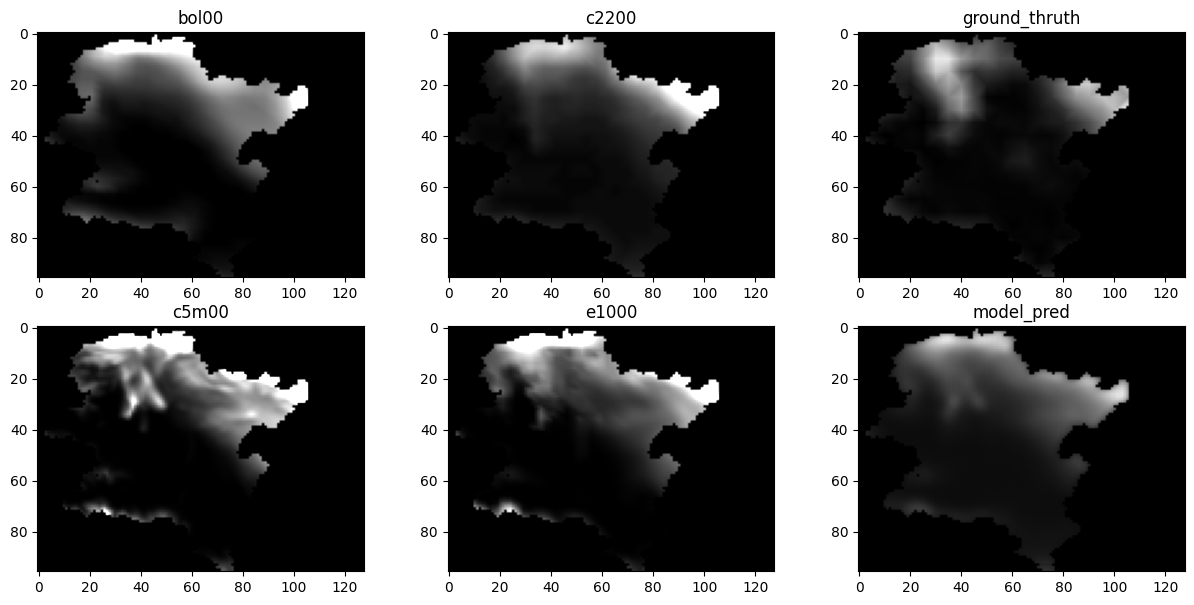

In [8]:
m=4
norm='linear'
vmin=0
vmax=1/20
fig, axs = plt.subplots(2, 3, figsize=(15, 7))
axs[0, 0].imshow(x[m][0], cmap='gray', norm=norm, vmin=vmin, vmax=vmax)
axs[0, 0].set_title('bol00')
axs[0, 1].imshow(x[m][1], cmap='gray', norm=norm, vmin=vmin, vmax=vmax)
axs[0, 1].set_title('c2200')
axs[1, 0].imshow(x[m][2], cmap='gray', norm=norm, vmin=vmin, vmax=vmax)
axs[1, 0].set_title('c5m00')
axs[1, 1].imshow(x[m][3], cmap='gray', norm=norm, vmin=vmin, vmax=vmax)
axs[1, 1].set_title('e1000')
axs[0, 2].imshow(y[m], cmap='gray', norm=norm, vmin=vmin, vmax=vmax)
axs[0, 2].set_title('ground_thruth')
axs[1, 2].imshow(logit_class[m], cmap='gray', norm=norm, vmin=vmin, vmax=vmax)
axs[1, 2].set_title('model_pred')

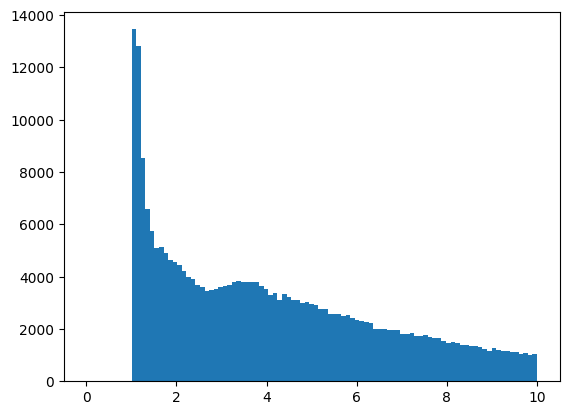

In [9]:
histo = (logit_class*case_study_max*mask).flatten()

plt.hist(histo[histo>0.1], bins=np.linspace(0,10, 100))
plt.show()

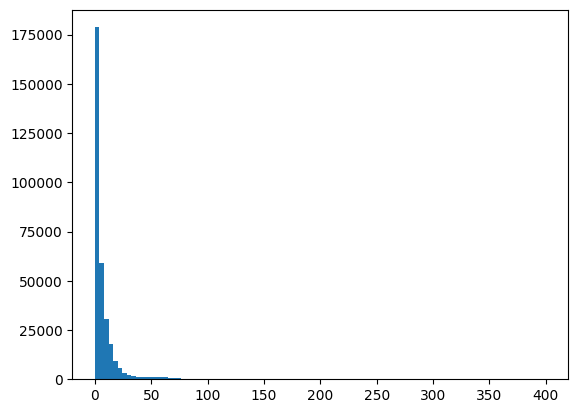

In [10]:
histo = (y*case_study_max*mask).flatten()

plt.hist(histo[histo>0.1], bins=np.linspace(0,400, 100))
plt.show()

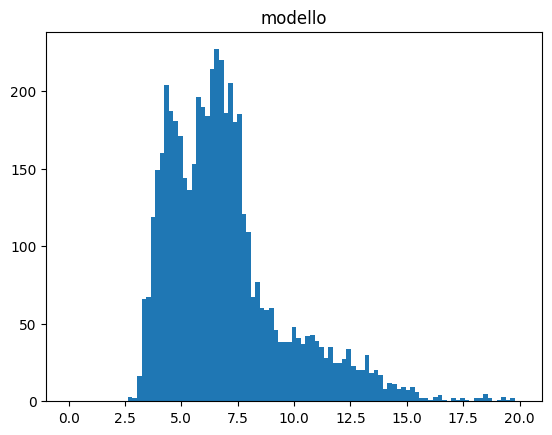

(38485.310604571554, (12288,))

In [11]:
y_r = np.reshape(y*mask, (63, 128*96))
logit_class_r = np.reshape(logit_class*mask, (63, 128*96))
RMSE = np.sqrt(np.square(y_r*case_study_max-logit_class_r*case_study_max).sum(0)/63)
plt.hist(RMSE[RMSE>0], bins=np.linspace(0,20, 100))
plt.title("modello")
plt.show()
RMSE.sum(), np.shape(RMSE)

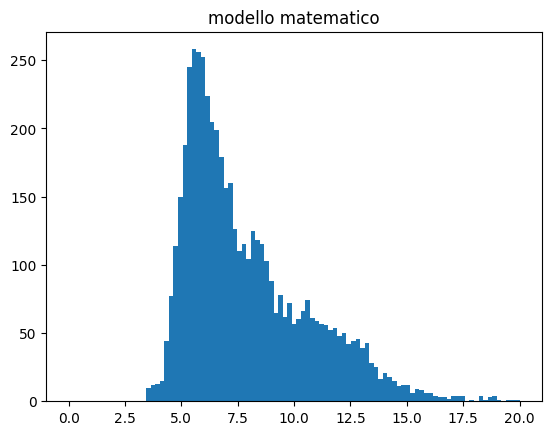

(42945.49910613713, (12288,))

In [12]:
x1_r = np.reshape(x[:, 1], (63, 128*96))
RMSE = np.sqrt(np.square(y_r*case_study_max-x1_r*case_study_max).sum(0)/63)
plt.hist(RMSE[RMSE>0], bins=np.linspace(0,20, 100))
plt.title("modello matematico")
plt.show()
RMSE.sum(), np.shape(RMSE)

In [13]:
np.sqrt(np.square(y*case_study_max-logit_class*case_study_max).sum()/(63*128*96))

5.517566044272606

In [14]:
from sklearn.metrics import root_mean_squared_error
sum=0
for i in range(63):
    sum+=np.square(root_mean_squared_error(y_r[i]*case_study_max, logit_class_r[i]*case_study_max))
sum/=63
np.sqrt(sum)

5.517566102912414

In [15]:
np.shape(x1_r)

(63, 12288)

In [16]:
import torch.nn as nn

In [17]:
(nn.MSELoss()(torch.tensor(logit_class).cpu(), torch.tensor(y).cpu())*case_study_max**2)**.5

tensor(5.5176)

In [18]:
logit_class.shape

(63, 96, 128)

In [19]:
logit_class.sum()

5846.0054

In [20]:
y.sum()

5164.935

In [21]:

trainer = pl.Trainer(
        accelerator='gpu' if cuda.is_available() else 'cpu',
        callbacks=[],
		log_every_n_steps=1
    )

model = SegmentationModel.load_from_checkpoint(Path("reports/unet/unet/epoch=85-val_rmse=7.04.ckpt"))
trainer.test(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2024-03-19 12:08:45.646306: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-19 12:08:46.656752: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]sum pred: 5285.208984375, sum pred*mask: 5285.208984375, sum y: 5164.935546875, sum y*mask: 5164.935546875
y shape: torch.Size([63, 96, 128]), y_hat shape: torch.Size([63, 96, 128])
np.rmse: 109.85965674393024
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        rmse NWP 0         │     8.525195121765137     │
│        rmse NWP 1         │     8.742253303527832     │
│        rmse NWP 2         │     8.632073402404785     │
│        rmse NWP 3         │    10.110584259033203     │
│         test rmse         │     5.604794502258301     │
└───────────────────────────┴───────────────────────────┘

[{'test rmse': 5.604794502258301,
  'rmse NWP 0': 8.525195121765137,
  'rmse NWP 1': 8.742253303527832,
  'rmse NWP 2': 8.632073402404785,
  'rmse NWP 3': 10.110584259033203}]

In [22]:
x.shape

(63, 4, 96, 128)

In [31]:
torch.sqrt(torch.absolute(torch.tensor(-3)))

tensor(1.7321)

In [33]:
logit_class.min()

0.0